<a href="https://colab.research.google.com/github/vmcru/MAIS-Hackathon-2021-polkadots/blob/main/segmentationclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.preprocessing import image
from keras.callbacks import TensorBoard 
from keras.utils.data_utils import get_file
from keras import utils as np_utils
from tensorflow.keras.applications import ResNet50, DenseNet121
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Input, Dropout, Activation, Flatten, BatchNormalization,ZeroPadding2D,concatenate,Lambda,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD,RMSprop, Adadelta
import os
import random
import numpy as np
from skimage import io
import cv2 
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, confusion_matrix,classification_report 
from scipy import interp
from itertools import cycle
from tqdm import tqdm
import json
from pathlib import Path

In [2]:
!pip install google.colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
f = open("/content/drive/MyDrive/segmentation/enumeration_segments.json",)
jsonfiledata = json.load(f)

In [8]:
save_path="/content/drive/MyDrive/segmentation/classification_results/"
print(os.path.isdir(save_path))
if os.path.isdir(save_path)==True:
  print("directory exists")
else:
  os.mkdir(save_path)
  print("new directory was created")
  

cell_count_class = ['1 Colony', '2 Colonies', '3 Colonies', '4 Colonies', '5 Colonies', '6 Colonies', 'Confluential','Outlier']
#cell_count_class = [0,1,2,3,4,5,6,7]
height=224 
width=224

datacount = 1000
maskfolder = "Masks"
segmentfolder = "Segments"

train_ratio=0.7
test_ratio=0.3
class_number=8

dataset_path="/content/drive/MyDrive/segmentation"
X_train=[]
y_train=[]
X_test=[]
y_test=[]


mask_img_path=os.path.join(dataset_path,maskfolder)
seg_img_path=os.path.join(dataset_path,segmentfolder)
mask_files=os.listdir(mask_img_path)
seg_files=os.listdir(seg_img_path)

train_number=round(len(seg_files)*train_ratio)
test_number=round(len(seg_files)*test_ratio)
print("\nTrain data= ",train_number,"\ntest data= ",test_number)




for i in tqdm(range(train_number)):

  a=random.choice(seg_files)
  
  seg_files=np.delete(seg_files,np.argwhere(seg_files==a))
  
  img_f=os.path.join(seg_img_path,a)
  img=cv2.imread(img_f)

  img=cv2.resize(img,(height,width))  
  img =img.astype(np.float32) / img.max()  
  img=image.img_to_array(img) 
  img = img.reshape((1,) + img.shape)       
  X_train.append(img) 
  searchname = a.split(".")[0]
  y_train.append(cell_count_class.index(jsonfiledata[searchname]["data"]["segment_type"]['text']))
  #['data'])
  seg_files=np.delete(seg_files,np.argwhere(seg_files==a))
  



for j in tqdm(seg_files):
      
  v=os.path.join(seg_img_path,j)
  
  img=cv2.imread(v)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  img=cv2.resize(img,(height,width))  
  img =img.astype(np.float32) / img.max()  
  img=image.img_to_array(img) 
  img = img.reshape((1,) + img.shape)
  
  searchname = j.split(".")[0]
  X_test.append(img) 
  y_test.append(cell_count_class.index(jsonfiledata[searchname]["data"]["segment_type"]['text']))
  #['data'])


True
directory exists

Train data=  701 
test data=  300


100%|██████████| 300/300 [00:50<00:00,  5.89it/s]


train dataset

In [9]:
def make_report(ii=0):
    matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    print(matrix)
    cr = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=cell_count_class)
    cm = np.array2string(matrix)
    #here we use the save path from the folder we wish tostore this file
    f = open(os.path.join(save_path,"report_"+str(ii)+".txt"), 'w')
    f.write('type cells \nClassification Report\n\n{}\n\nConfusion Matrix\n\n{}\n'.format(cr, cm))
    f.close()

In [10]:
X_train=np.array(X_train,dtype=np.float32)
X_train = X_train.reshape(X_train.shape[0], height, width, 3)

X_test=np.array(X_test,dtype=np.float32)
X_test = X_test.reshape(X_test.shape[0], height, width, 3)

y_train = np.array(y_train, dtype=np.float32)
y_train = tf.keras.utils.to_categorical(y_train, class_number)

y_test = np.array(y_test, dtype=np.float32)
y_test = tf.keras.utils.to_categorical(y_test, class_number)

In [11]:
 #Training Process
EPOCHS=1
BATCH_SIZE=16
x_fold=1
#optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-07, decay=0.0)
optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
#optimizer=SGD(lr=0.001, momentum=0.0, nesterov=False)
#optimizer=RMSprop(lr=0.0001, rho=0.9)

metric="accuracy" 
loss="categorical_crossentropy" 
model_checkpoint_callback=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True,save_weights_only=True,)
callbacks=[model_checkpoint_callback]


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
def plot_roc(ii=0):

    # Plot linewidth.
    lw = 2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(class_number):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(class_number)]))

    # interpolate all ROC curves 
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(class_number):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # compute AUC
    mean_tpr /= class_number

    # Plot all ROC curves
    plt.close("all")
    all_plt=plt.figure(1)

    colors = cycle(["blue","red", "purple", "gray", "pink", "brown"])
    for i, color in zip(range(class_number), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='{0} (area = {1:0.3f})'
                 ''.format(rock_classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves of count classes')
    plt.legend(loc="lower right")
    plt.show
    all_plt.savefig(save_path+"all_auc_"+str(ii)+".jpg",dpi=150)

10/10 [==============================] - 2s 192ms/step - loss: 5.7631 - accuracy: 0.4800
[5.736441612243652, 0.48644793033599854]
[5.7631378173828125, 0.47999998927116394]


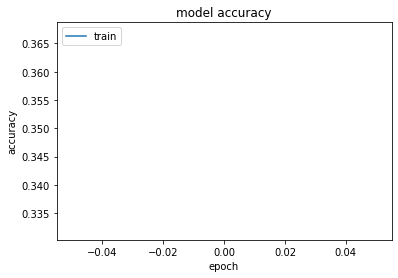

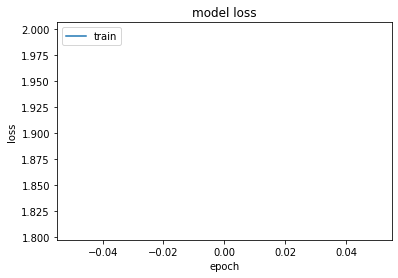

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


NameError: ignored

<Figure size 432x288 with 0 Axes>

In [14]:
for i in range(x_fold):
  input_shape=(height, width, 3)
  #Transfer_Model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
  Transfer_Model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
  
  add_model = Sequential() # groups a linear stack of layers into a tf.keras.Model; training and inference on this model

  add_model.add(Flatten()) # what is getting flattened? the RGB image? to what dimesions? vectorize? 
  add_model.add(BatchNormalization()) # what is batch in this case? how is it defined? for optimizer? 
  add_model.add(Dense(16, activation='relu')) # regular ol' neural net layer, with output of size (None, 16) (None refers to the size of the batch; see https://pgaleone.eu/tensorflow/2018/07/28/understanding-tensorflow-tensors-shape-static-dynamic/)
  add_model.add(Dropout(0.25)) # 25 % of units dropped for regularization; only true for training (not applied during prediction)
  add_model.add(BatchNormalization())
        
  add_model.add(Dense(class_number, activation='softmax'))

  model = Model(inputs=Transfer_Model.input, outputs=add_model(Transfer_Model.output))

  model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
  
  history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
  #predictions
  y_pred= model.predict(X_test)
  y_pred=np.argmax(y_pred,axis=1).astype(np.float32)
  y_pred = tf.keras.utils.to_categorical(y_pred, class_number)

  train_score = model.evaluate(X_train, y_train)
  test_score = model.evaluate(X_test, y_test)
  print(train_score)
  print(test_score)

  #Plot accuracy 
  plt.close("all")
  plt.plot(history.history['accuracy'])
  #plt.plot(history.history['val_accuracy'])  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig(os.path.join(save_path,"acc_"+str(i)+".jpg"),dpi=150)
  #Plot loss
  plt.close("all")
  plt.plot(history.history['loss'])
  #plt.plot(history.history['val_accuracy'])
      
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  plt.savefig(os.path.join(save_path,"loss_"+str(i)+".jpg"),dpi=150)
  #Plot ROC
  plot_roc(i)
  make_report(i)